# **Install Necessary Dependencies**

In [5]:
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable


# **Connect to Google Drive to Access the Dataset**


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

# **Import Necessary Libraries**

In [1]:
import os
import cv2
import torch
import time
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.mkdir('cropped_dataset')
# os.mkdir('yolo_detections_V8')
# os.mkdir('yolo_detections_V9')
# os.mkdir('yolo_detections_V10')
# os.mkdir('yolo_detections_V11')
    
warnings.filterwarnings('ignore')

In [70]:
# base_dir='/content/drive/MyDrive/CV_Dataset'
# save_dir='/content/cropped_dataset'
# yolov8_detections='/content/yolo_detections'

base_dir='dataset'
save_dir='cropped_dataset'
yolov8_detections='yolo_detections_V8'
yolov9_detections='yolo_detections_V9'
yolov10_detections="yolo_detections_V10"
yolov11_detections="yolo_detections_V11"

encoder=LabelEncoder()
file_paths=os.listdir(base_dir)
file_paths=[i for i in file_paths if ".zip" not in i]
random.shuffle(file_paths)
# unique_names=[i.split('_')[0] for i in file_paths]
unique_names=[]
for i in file_paths:
    i=i.split('_')
    name=''
    if len(i)==3:
        name=i[0]+i[1]
    else:
        name=i[0]
    unique_names.append(name)
unique_names=list(set(unique_names))
max_name_length = max(len(name) for name in unique_names)
encoded_names=encoder.fit_transform(unique_names)


In [71]:
print("Total Dataset : ",len(file_paths)//2," Student Card Images (Front and Back)")

Total Dataset :  18  Student Card Images (Front and Back)


In [72]:
print('---Name---     ---Label---')
name_to_label={}
label_to_name={}
for name,label in zip(unique_names,encoded_names):
    print(f" {name:<{max_name_length}}        {label}")
    name_to_label[name]=label
    label_to_name[label]=name

---Name---     ---Label---
 ShahramAli            13
 ZaidZaki              15
 diddy                 17
 AbdulRafay            0
 HafizHammad           3
 RaffayKhan            10
 SarimAeyzaz           12
 OwaisZahid            8
 ZaraarMalik           16
 MoawizYamin           6
 MaaheenSiddiqi        5
 SaribAli              11
 MuhammadOaun          7
 AbdulSubhan           1
 QasimSaeed            9
 HakimAli              4
 Wajeeh                14
 AnsabAlam             2


In [34]:
name_to_label['ZaraarMalik'] , label_to_name[16]

(16, 'ZaraarMalik')

In [35]:
file_paths

['Ansab_Alam_back.jpg',
 'Maaheen_Siddiqi_back.png',
 'Abdul_Subhan_Front.png',
 'Muhammad_Oaun_back.jpg',
 'Raffay_Khan_front.jpg',
 'AbdulRafay_back.jpg',
 'Wajeeh_front.jpg',
 'QasimSaeed_back.jpg',
 'Sarib_Ali_front.jpg',
 'ShahramAli_back.jpg',
 'OwaisZahid_back.jpg',
 'SarimAeyzaz_back.jpg',
 'Moawiz_Yamin_back.jpg',
 'Hakim_Ali_back.jpg',
 'Zaraar_Malik_back.jpg',
 'ZaidZaki_front.jpg',
 'Wajeeh_back.jpg',
 'Raffay_Khan_back.jpg',
 'AbdulRafay_front.jpg',
 'diddy_back.jpg',
 'Maaheen_Siddiqi_front.png',
 'Muhammad_Oaun_front.jpg',
 'Moawiz_Yamin_front.jpg',
 'diddy_front.jpg',
 'Sarib_Ali_back.jpg',
 'Ansab_Alam_front.jpg',
 'Abdul_Subhan_Back.png',
 'ShahramAli_front.jpg',
 'Zaraar_Malik_front.jpg',
 'Hakim_Ali_front.jpg',
 'OwaisZahid_front.jpg',
 'SarimAeyzaz_front.jpg',
 'ZaidZaki_back.jpg',
 'HafizHammad_front.jpg',
 'HafizHammad_back.jpg',
 'QasimSaeed_front.jpg']

# **Hardcode Cropping**

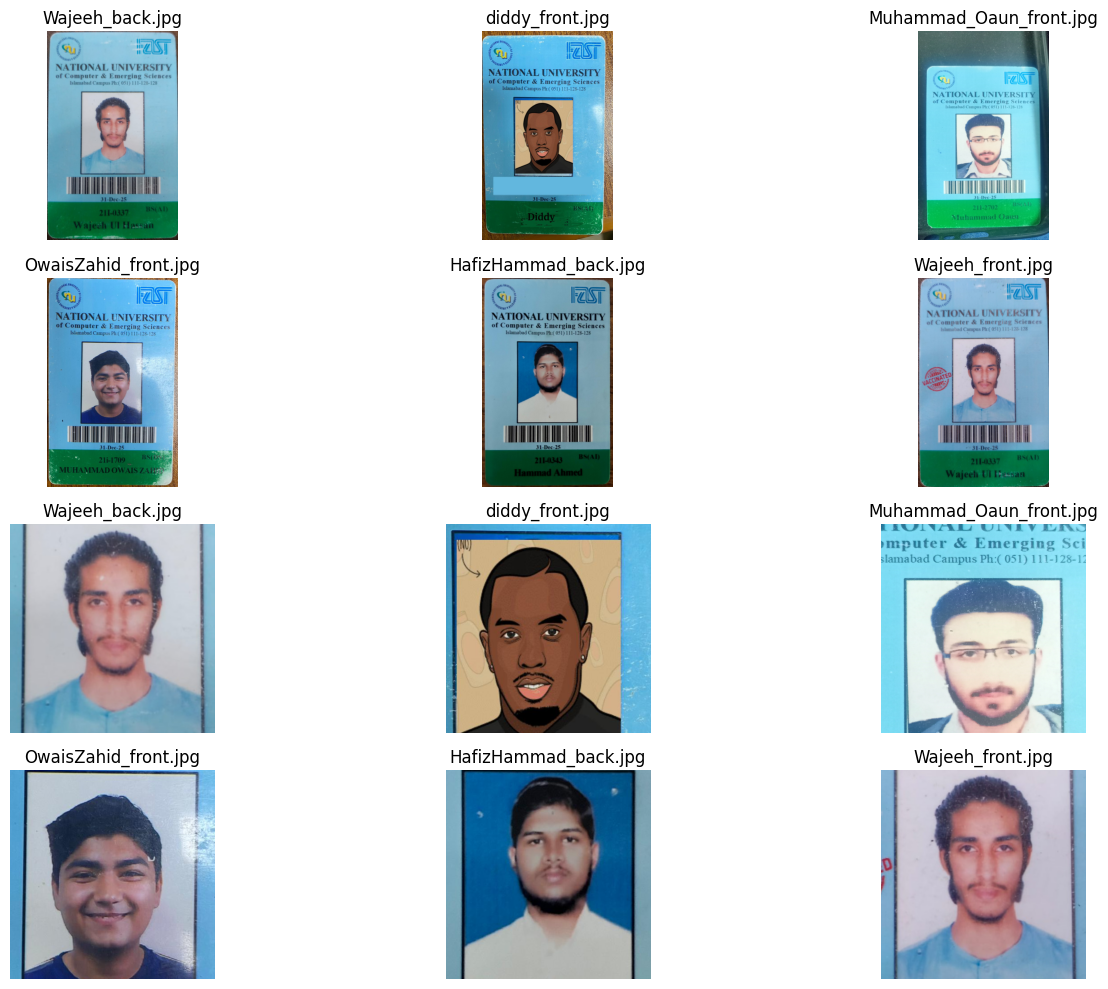

In [27]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
for i, file_path in enumerate(file_paths):
    col = i // 2
    row = i % 2

    img = cv2.imread(os.path.join(base_dir, file_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    resized_img = cv2.resize(img, (800, 1280))

    center_y = resized_img.shape[0] // 2
    center_x = resized_img.shape[1] // 2

    start_y = center_y - 250
    end_y = center_y + 200
    start_x = center_x - 220
    end_x = center_x + 220

    cropped_img = resized_img[start_y:end_y, start_x:end_x]
    if i<6:
      axes[row, col].imshow(resized_img)
      axes[row+2,col].imshow(cropped_img)
      axes[row, col].axis('off')
      axes[row+2, col].axis('off')

      axes[row, col].set_title(file_path)
      axes[row+2, col].set_title(file_path)

    cv2.imwrite(os.path.join(save_dir,file_path),cropped_img)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the plot

In [32]:
model_v8 = YOLO("yolov8m.pt")
model_v9 = YOLO("yolov9m.pt")
model_v10 = YOLO("yolov10m.pt")
model_v11 = YOLO("yolo11m.pt")
model_list=[model_v8,model_v9,model_v10,model_v11]
model_dirs=[yolov8_detections,yolov9_detections,yolov10_detections,yolov11_detections]

# **Cropping using a pre-trained model**


0: 640x416 1 person, 1 book, 235.7ms
Speed: 3.0ms preprocess, 235.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)
(462, 384, 3)
yolo_detections_V8/Wajeeh_back.jpg

0: 640x448 1 person, 232.0ms
Speed: 3.1ms preprocess, 232.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)
(453, 386, 3)
yolo_detections_V8/OwaisZahid_front.jpg

0: 640x448 1 person, 1 tie, 1 book, 244.3ms
Speed: 3.0ms preprocess, 244.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)
(436, 373, 3)
yolo_detections_V8/diddy_front.jpg

0: 640x448 1 person, 1 book, 239.6ms
Speed: 3.5ms preprocess, 239.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)
(484, 382, 3)
yolo_detections_V8/HafizHammad_back.jpg

0: 640x384 1 person, 1 book, 200.5ms
Speed: 3.0ms preprocess, 200.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)
(1237, 940, 3)
yolo_detections_V8/Muhammad_Oaun_front.jpg

0: 640x416 1 person, 1 book, 200.6ms
Speed: 3.0ms prepro

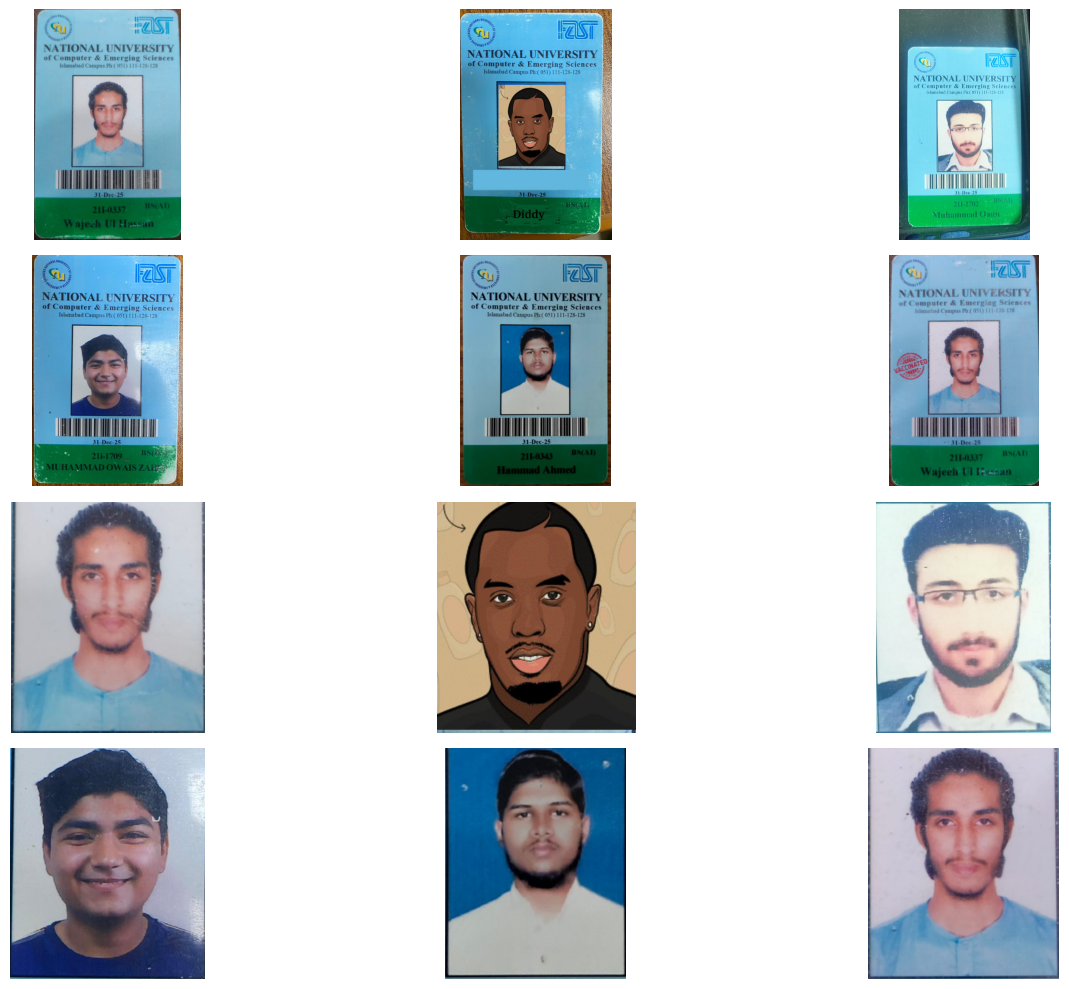

In [39]:
detection_times = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10))
for model,paths in zip(model_list,model_dirs):
  start_time = time.time()  # Start timing
  for i, file_path in enumerate(file_paths):
      col = i // 2
      row = i % 2
      img = cv2.imread(os.path.join(base_dir, file_path))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      results = model(img)

      boxes = results[0].boxes.xyxy.cpu().numpy()
      confidences = results[0].boxes.conf.cpu().numpy()
      class_ids = results[0].boxes.cls.cpu().numpy()

      face_indices = np.where(class_ids == 0)[0]
      face_boxes = boxes[face_indices]

      # Extract and display the detected region
      detected_img=''
      for box in face_boxes:
          x1, y1, x2, y2 = box.astype(int)
          detected_img = img[y1:y2, x1:x2]
          print(detected_img.shape)
          if i<6:
            axes[row,col].imshow(img)
            axes[row,col].axis('off')
            axes[row+2, col].imshow(detected_img)
            axes[row+2, col].axis('off')
          break
      cv2.imwrite(os.path.join(paths,file_path),detected_img)
      print(paths+'/'+file_path)
    
  end_time = time.time()  # End timing
  total_time = end_time - start_time
  detection_times.append(total_time)  # Append total time for the model

plt.tight_layout()
plt.show()

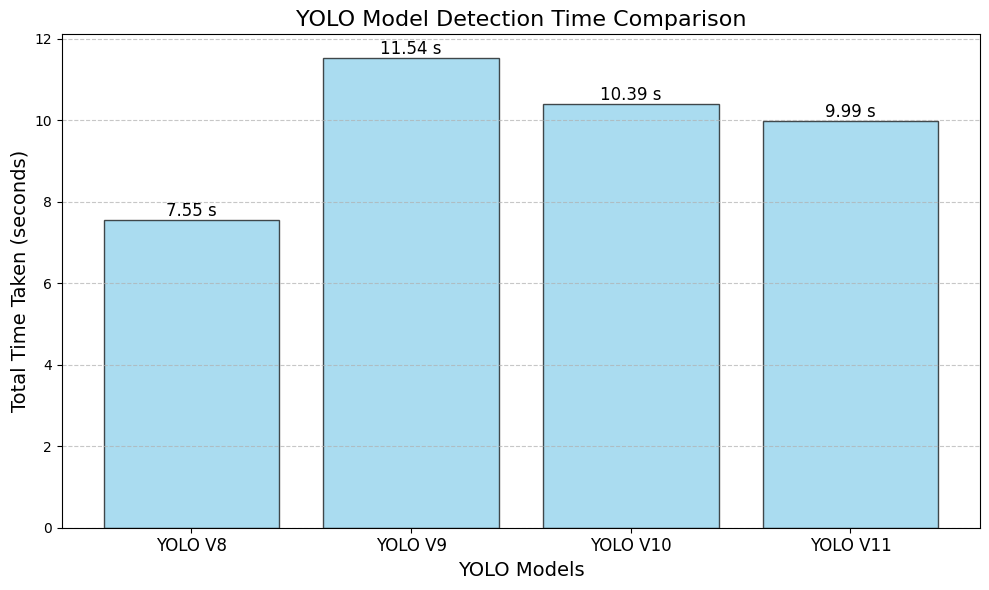

In [40]:
model_names = ["YOLO V8", "YOLO V9", "YOLO V10", "YOLO V11"]  # Names for reference

plt.figure(figsize=(10, 6))
bar_positions = np.arange(len(model_list))
plt.bar(bar_positions, detection_times, color='skyblue', alpha=0.7, edgecolor='black')

# Add titles and labels
plt.title("YOLO Model Detection Time Comparison", fontsize=16)
plt.xlabel("YOLO Models", fontsize=14)
plt.ylabel("Total Time Taken (seconds)", fontsize=14)
plt.xticks(bar_positions, model_names, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the bar chart with the exact time values
for i, time_taken in enumerate(detection_times):
    plt.text(bar_positions[i], time_taken + 0.1, f"{time_taken:.2f} s", ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# **Preparing dataset for Transfer Learning**

In [36]:
train_paths=[yolov8_detections+'/'+i for i in os.listdir(yolov8_detections) if 'front' in i or 'Front' in i]
train_paths.extend(train_paths)
test_paths=[yolov8_detections+'/'+i for i in os.listdir(yolov8_detections) if 'back' in i or 'Back' in i]

train_labels=[]
for i in train_paths:
    i=i.split('/')[-1].split('_')
    if len(i)>2:
        i=i[0]+i[1]
    else:
        i=i[0]
    train_labels.append(name_to_label[i])
test_labels=[]
for i in test_paths:
    i=i.split('/')[-1].split('_')
    if len(i)>2:
        i=i[0]+i[1]
    else:
        i=i[0]
    test_labels.append(name_to_label[i])

In [37]:
len(train_paths)

36

# **Defining Custom Dataset**

In [57]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, num_classes,transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.num_classes=num_classes

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(image_path).convert('RGB')
        label = self.dataframe.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        # torch_label=torch.tensor(label,dtype=torch.float32)
        one_hot_label = np.zeros(self.num_classes)
        one_hot_label[label] = 1
        one_hot_label = torch.tensor(one_hot_label, dtype=torch.float32)  # Convert to PyTorch tensor
        return image, one_hot_label

In [58]:
transform = transforms.Compose([
    # Random augmentations for generalization
    transforms.RandomHorizontalFlip(p=0.3),           # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.3),             # Random vertical flip
    transforms.RandomRotation(degrees=15),            # Random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.Resize((420, 420)),                    # Resize back to 420x420
    transforms.ToTensor(),                            # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [59]:
train_frame=pd.DataFrame({'label':train_labels,'file_path':train_paths})
train_frame.head()

,label,file_path
0,0,yolo_detections_V8/AbdulRafay_front.jpg
1,1,yolo_detections_V8/Abdul_Subhan_Front.png
2,2,yolo_detections_V8/Ansab_Alam_front.jpg
3,17,yolo_detections_V8/diddy_front.jpg
4,3,yolo_detections_V8/HafizHammad_front.jpg


In [60]:
test_frame=pd.DataFrame({'label':test_labels,'file_path':test_paths})
test_frame.head()

,label,file_path
0,0,yolo_detections_V8/AbdulRafay_back.jpg
1,1,yolo_detections_V8/Abdul_Subhan_Back.png
2,2,yolo_detections_V8/Ansab_Alam_back.jpg
3,17,yolo_detections_V8/diddy_back.jpg
4,3,yolo_detections_V8/HafizHammad_back.jpg


# **Training and Testing Loaders**

In [61]:
train_ds = CustomDataset(train_frame, len(unique_names),transform=transform)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

test_ds = CustomDataset(test_frame, len(unique_names),transform=transform)
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False)

# **Simpl CNN Architecture**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# with 420 size
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Two Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Output: [16, 420, 420]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # Output: [32, 420, 420]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)       # Output after pool: [32, 210, 210]

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 210 * 210, 128)  # Hidden layer
        self.fc2 = nn.Linear(128, num_classes)     # Output layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # First convolutional layer
        x = F.relu(self.conv1(x))
        # Second convolutional layer
        x = self.pool(F.relu(self.conv2(x)))       # Max pooling after 2nd conv

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten [batch_size, 32, 210, 210] -> [batch_size, 32*210*210]
        x = F.relu(self.fc1(x))    # First fully connected layer
        x = self.fc2(x)            # Output layer
        # x = self.sigmoid(x)
        return x
# with 420 size

class SimpleFCNN(nn.Module):
    def __init__(self, num_classes, input_size=420):
        super(SimpleFCNN, self).__init__()
        # Compute the flattened input size: 3 channels * image_height * image_width
        flattened_size = 3 * input_size * input_size
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 1024)  # First hidden layer
        self.fc2 = nn.Linear(1024, 512)            # Second hidden layer
        self.fc3 = nn.Linear(512, 128)             # Third hidden layer
        self.fc4 = nn.Linear(128, num_classes)     # Output layer
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # Flatten the input tensor: [batch_size, 3, 420, 420] -> [batch_size, 3*420*420]
        x = x.view(x.size(0), -1)
        
        # Pass through fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # No activation for the output layer (optional sigmoid can be applied externally)
        # x = self.sigmoid(x)
        
        return x



In [85]:
import torch.optim as optim

# Define learning rate and loss function
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
# Example usage:
num_classes = len(unique_names)  # Example number of classes
model_CNN = SimpleCNN(num_classes=num_classes)
model_FCNN = SimpleFCNN(num_classes=num_classes)
# Create optimizer
optimizer_CNN = optim.Adam(model_CNN.parameters(), lr=learning_rate)
optimizer_FCNN = optim.Adam(model_FCNN.parameters(), lr=learning_rate)

# Training loop
num_epochs = 30  # Example number of epochs


In [86]:
from tqdm import tqdm
import numpy as np
best_loss=999
patience=3
counter=0
for epoch in range(num_epochs):
# while(True):
    running_loss = 0
    # Wrap the inner loop with tqdm
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for batch in pbar:
            images = batch[0].to(device)
            labels = batch[1].to(device)

            optimizer_CNN.zero_grad()
            outputs = model_CNN(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_CNN.step()

            running_loss += loss.item()
            # Update tqdm description with the current average loss
            pbar.set_postfix(loss=np.round(running_loss / (pbar.n + 1), 2))
    if best_loss> np.round(running_loss/len(train_loader),2):
        best_loss=np.round(running_loss/len(train_loader),2)
    else:
        patience=patience-1
    if patience==0:
        print('\nReached Early Stopping Criteria\n')
        break


Epoch 14/30: 100%|██████████| 18/18 [00:12<00:00,  1.41batch/s, loss=0.76]


Reached Early Stopping Criteria



In [87]:
from tqdm import tqdm
import numpy as np
best_loss=999
patience=3
counter=0
for epoch in range(num_epochs):
# while(True):
    running_loss = 0
    # Wrap the inner loop with tqdm
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for batch in pbar:
            images = batch[0].to(device)
            labels = batch[1].to(device)

            optimizer_FCNN.zero_grad()
            outputs = model_FCNN(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_FCNN.step()

            running_loss += loss.item()
            # Update tqdm description with the current average loss
            pbar.set_postfix(loss=np.round(running_loss / (pbar.n + 1), 2))
    if best_loss> np.round(running_loss/len(train_loader),2):
        best_loss=np.round(running_loss/len(train_loader),2)
    else:
        patience=patience-1
    if patience==0:
        print('\nReached Early Stopping Criteria\n')
        break


Epoch 10/30: 100%|██████████| 18/18 [00:27<00:00,  1.53s/batch, loss=3.36]


Reached Early Stopping Criteria



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import torch
def eval(model):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
            images = batch[0].to(device)
            labels = batch[1].to(device)
            labels= torch.argmax(labels, dim=1)

            outputs = model(images)
            if outputs.size(1) > 1:
                # Multiclass case: Get the predicted class as the index of the max logit
                preds = torch.argmax(outputs, dim=1)
            else:
                # Binary case: Apply threshold of 0.5
                preds = (outputs > 0.5).long()

            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)

    # Display results
    print("\nEvaluation Results:")
    print(f"Accuracy       : {np.round(accuracy*100,1)}")
    
    print('\nReal Label--------------Predicted Label')
    
    for real,preidcted in zip(all_labels,all_preds):
        print(f" {label_to_name[real]:<{max_name_length}}        {label_to_name[preidcted]}")



In [93]:
eval(model_CNN)
eval(model_FCNN)

Evaluating: 100%|██████████| 9/9 [00:02<00:00,  4.27batch/s]



Evaluation Results:
Accuracy       : 83.3


Evaluating: 100%|██████████| 9/9 [00:01<00:00,  6.19batch/s]


Evaluation Results:
Accuracy       : 38.9


In [101]:
from ultralytics import YOLO
import pickle
from tqdm import tqdm


with open('cnn_model.pkl' , "rb") as file:
    model_CNN=pickle.load(file)
eval(model_CNN)


Evaluating: 100%|██████████| 9/9 [00:02<00:00,  4.09batch/s]


Evaluation Results:
Accuracy       : 83.3

Real Label--------------Predicted Label
 AbdulRafay            AbdulRafay
 AbdulSubhan           AbdulSubhan
 AnsabAlam             AnsabAlam
 diddy                 diddy
 HafizHammad           HafizHammad
 HakimAli              HakimAli
 MaaheenSiddiqi        MaaheenSiddiqi
 MoawizYamin           MoawizYamin
 MuhammadOaun          MuhammadOaun
 OwaisZahid            OwaisZahid
 QasimSaeed            OwaisZahid
 RaffayKhan            AbdulSubhan
 SaribAli              SaribAli
 SarimAeyzaz           MoawizYamin
 ShahramAli            ShahramAli
 Wajeeh                Wajeeh
 ZaidZaki              ZaidZaki
 ZaraarMalik           OwaisZahid


In [93]:
with open('fcnn_model.pkl' , "rb") as file:
    model_FCNN=pickle.load(file)
eval(model_FCNN)

Evaluating: 100%|██████████| 9/9 [00:01<00:00,  4.66batch/s]


Evaluation Results:
Accuracy       : 38.9

Real Label--------------Predicted Label
 AbdulRafay            HafizHammad
 AbdulSubhan           ShahramAli
 AnsabAlam             QasimSaeed
 diddy                 diddy
 HafizHammad           HafizHammad
 HakimAli              ShahramAli
 MaaheenSiddiqi        AnsabAlam
 MoawizYamin           MoawizYamin
 MuhammadOaun          MuhammadOaun
 OwaisZahid            diddy
 QasimSaeed            QasimSaeed
 RaffayKhan            SaribAli
 SaribAli              SaribAli
 SarimAeyzaz           QasimSaeed
 ShahramAli            ShahramAli
 Wajeeh                ShahramAli
 ZaidZaki              QasimSaeed
 ZaraarMalik           diddy


In [ ]:
# from ultralytics import YOLO
# import pickle

# model_v8=YOLO('yolov8m.pt')
# with open('cnn_model.pkl' , "rb") as file:
#     custom_model=pickle.load(file)

In [ ]:
# def detect_face_yolo(image, yolo_model):
#     results = yolo_model(image)
#     boxes = results[0].boxes.xyxy.cpu().numpy()
#     class_ids = results[0].boxes.cls.cpu().numpy()

#     # Filter for faces (assuming class_id = 0 is for faces in your dataset)
#     face_indices = np.where(class_ids == 0)[0]
#     face_boxes = boxes[face_indices]

#     if len(face_boxes) > 0:
#         # Use the first detected face box
#         x1, y1, x2, y2 = face_boxes[0].astype(int)
#         detected_face = image[y1:y2, x1:x2]
#         return detected_face
#     return None

# def process_frame(frame, yolo_model, custom_model):
#     # Detect the face
#     detected_face = detect_face_yolo(frame, yolo_model)
#     if detected_face is None:
#         return "No face detected"

#     # Convert to RGB and PIL format
#     detected_face_rgb = cv2.cvtColor(detected_face, cv2.COLOR_BGR2RGB)
#     pil_image = Image.fromarray(detected_face_rgb)

#     # Apply transformations
#     transformed_image = transform(pil_image)

#     # Add a batch dimension
#     input_tensor = transformed_image.unsqueeze(0)

#     # Make predictions
#     custom_model.eval()
#     with torch.no_grad():
#         prediction = custom_model(input_tensor)

#     # Return predicted class
#     predicted_class = torch.argmax(prediction, dim=1).item()
#     return predicted_class


In [ ]:
# import matplotlib.pyplot as plt
# cap = cv2.VideoCapture(0)  # Default camera

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         print("Error: Could not read frame.")
#         break

#     # Process the frame
#     predicted_class = process_frame(frame, model_v8, custom_model)

#     # Display the prediction on the frame
#     cv2.putText(frame, f"Predicted Class: {predicted_class}", (10, 30),
#                 cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

#     # Convert BGR to RGB for Matplotlib
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     # Display using Matplotlib
#     plt.imshow(frame_rgb)
#     plt.title(f"Predicted Class: {predicted_class}")
#     plt.axis('off')
#     plt.show(block=False)
#     plt.pause(0.001)

#     # Press 'q' to quit
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# plt.close()
# cap.release()


Error: Could not read frame.
